### Tomar un ejemplo de los bots utilizados (uno de los dos) y construir el propio.
### Sacar conclusiones de los resultados.

#### IMPORTANTE: Recuerde para la entrega del ejercicio debe quedar registrado en el colab las preguntas y las respuestas del BOT para que podamos evaluar el desempeño final.

#### Agrego depencendias

In [87]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout


import stanza
import spacy_stanza

import re
import unicodedata

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

In [88]:
# Descargar el diccionario en español
stanza.download("es")
# Configurar el pipeline de procesamiento de lenguaje natural con Spacy y Stanza
nlp = spacy_stanza.load_pipeline("es")

2023-05-29 22:42:54 INFO: Downloading default packages for language: es (Spanish) ...
2023-05-29 22:42:55 INFO: File exists: /Users/matias/stanza_resources/es/default.zip
2023-05-29 22:42:58 INFO: Finished downloading models and saved to /Users/matias/stanza_resources.
2023-05-29 22:42:58 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-05-29 22:43:00 INFO: Loading these models for language: es (Spanish):
| Processor    | Package  |
---------------------------
| tokenize     | ancora   |
| mwt          | ancora   |
| pos          | ancora   |
| lemma        | ancora   |
| constituency | combined |
| depparse     | ancora   |
| sentiment    | tass2020 |
| ner          | conll02  |

2023-05-29 22:43:00 WARNING: GPU requested, but is not available!
2023-05-29 22:43:00 INFO: Using device: cpu
2023-05-29 22:43:00 INFO: Loading: tokenize
2023-0

#### Preproceso y elimino STOP WORDS.

In [89]:
def preprocess_clean_text(text):
    # Sacar tildes de las palabras
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]'
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]'
    # Quitar números
    text = re.sub(pattern, '', text)
    # Quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])

    # Tokenizar el texto y eliminar los stop words
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]

    return ' '.join(tokens)


#### Adapto preguntas y respuestas a un consultorio médico

In [90]:
dataset = {
    "intents": [
        {
            "tag": "bienvenida",
            "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?"],
            "responses": ["¡Hola!", "Hola, ¿cómo estás?"],
        },
        {
            "tag": "turnos",
            "patterns": ["¿Cómo puedo solicitar un turno?", "¿Cuál es el procedimiento para agendar una cita?"],
            "responses": ["Puedes solicitar un turno llamando a nuestro número de contacto o visitando nuestra página web."],
        },
        {
            "tag": "horarios",
            "patterns": ["¿Cuáles son los horarios de atención?", "¿En qué horarios trabajan?"],
            "responses": ["Nuestros horarios de atención son de lunes a viernes de 9:00 a.m. a 5:00 p.m."],
        },
        {
            "tag": "especialidades médicas",
            "patterns": ["¿Qué especialidades médicas ofrecen?", "¿Con qué especialistas cuentan?"],
            "responses": ["Contamos con especialistas en diversas áreas, como cardiología, pediatría, ginecología, entre otros. ¿En qué área necesitas atención?"],
        },
        {
            "tag": "pago y facturación",
            "patterns": ["¿Cuáles son los métodos de pago?", "¿Cómo puedo pagar la consulta?"],
            "responses": ["Aceptamos efectivo, tarjetas de crédito y débito. Al finalizar la consulta, se emitirá la correspondiente factura."],
        },
        {
            "tag": "expediente médico",
            "patterns": ["¿Cómo puedo acceder a mi expediente médico?", "¿Dónde puedo consultar mi historial médico?"],
            "responses": ["Puedes solicitar acceso a tu expediente médico en nuestra recepción. Te proporcionaremos las instrucciones para acceder a él de forma segura."],
        },
        {
            "tag": "recetas y medicamentos",
            "patterns": ["¿Cómo obtengo una receta médica?", "¿Dónde puedo conseguir los medicamentos recetados?"],
            "responses": ["Nuestros médicos pueden proporcionarte una receta médica durante la consulta. Puedes adquirir los medicamentos recetados en nuestra farmacia o en la que prefieras."],
        },
        {
            "tag": "resultados de análisis",
            "patterns": ["¿Cómo puedo obtener los resultados de mis análisis?", "¿Cuándo estarán listos los resultados de mis pruebas?"],
            "responses": ["Una vez que los resultados estén disponibles, nuestro personal se pondrá en contacto contigo para coordinar la entrega o brindarte las instrucciones correspondientes."],
        },
        {
            "tag": "procedimientos médicos",
            "patterns": ["¿Cuáles son los procedimientos médicos que realizan?", "¿Qué tipo de cirugías realizan?"],
            "responses": ["Contamos con una amplia gama de procedimientos médicos, incluyendo cirugías menores, intervenciones quirúrgicas especializadas y más. ¿En qué procedimiento estás interesado?"],
        },
        {
            "tag": "obras sociales",
            "patterns": ["¿Aceptan Obras Sociales?", "¿Qué Obras Sociales están afiliadas?","¿Aceptan Prepagas?"],
            "responses": ["Sí, aceptamos la mayoría de las Obras Sociales. Te recomendamos consultar con tu prepaga u obra social para obtener más información sobre nuestra cobertura."],
        },
        {
            "tag": "enfermedades comunes",
            "patterns": ["¿Qué enfermedades comunes tratan?", "¿Cuáles son las enfermedades más frecuentes que atienden?"],
            "responses": ["Atendemos una amplia variedad de enfermedades comunes, como resfriados, gripes, infecciones del tracto urinario, alergias, entre otras. ¿Cuál es tu situación actual?"],
        },
        {
            "tag": "prevención y cuidado de la salud",
            "patterns": ["¿Qué medidas puedo tomar para prevenir enfermedades?", "¿Cómo puedo cuidar mi salud?"],
            "responses": ["Es importante mantener una dieta equilibrada, realizar ejercicio regularmente, descansar lo suficiente y llevar a cabo las revisiones médicas periódicas. ¿Necesitas información específica sobre algún tema de prevención?"],
        },
        {
            "tag": "emergencias médicas",
            "patterns": ["¿Qué debo hacer en caso de una emergencia médica?", "¿Cuál es su protocolo para situaciones de urgencia?"],
            "responses": ["En caso de una emergencia médica, te recomendamos llamar al número de emergencia local o dirigirte al hospital más cercano de inmediato. Si tienes alguna afección médica subyacente, por favor, infórmanos para brindarte una mejor asistencia en situaciones de urgencia."],
        },
        {
            "tag": "información sobre tratamientos",
            "patterns": ["¿Pueden brindarme información sobre un tratamiento en particular?", "¿Qué puedo esperar de un tratamiento específico?"],
            "responses": ["Con gusto te proporcionaremos información sobre tratamientos específicos. Por favor, indícanos el nombre del tratamiento o la condición médica para la cual estás buscando información."],
        },
        {
            "tag": "preguntas sobre síntomas",
            "patterns": ["Tengo ciertos síntomas, ¿qué podría ser?", "¿Cuál podría ser la causa de mis síntomas?"],
            "responses": ["Entendemos tus preocupaciones. Sin embargo, es importante realizar una evaluación médica adecuada para determinar la causa de tus síntomas. Te recomendamos agendar una consulta con uno de nuestros especialistas para un diagnóstico preciso."],
        },
        {
            "tag": "consultas de seguimiento",
            "patterns": ["Ya tuve una consulta anterior, ¿necesito hacer un seguimiento?", "¿Cuándo debo programar una consulta de seguimiento?"],
            "responses": ["Dependiendo de tu condición médica, es posible que necesites una consulta de seguimiento para evaluar tu progreso y ajustar el tratamiento si es necesario. Te recomendamos comunicarte con nosotros para programar una consulta de seguimiento."],
        },
        {
            "tag": "exámenes médicos",
            "patterns": ["¿Qué exámenes médicos recomiendan?", "¿Cuándo debo hacerme exámenes de rutina?"],
            "responses": ["Los exámenes médicos recomendados varían según la edad, el género y los factores de riesgo individuales. Te recomendamos agendar una consulta para que podamos evaluar tus necesidades y brindarte una guía personalizada sobre los exámenes médicos que debes realizarte."],
        },
        {
            "tag": "estudios de imagen",
            "patterns": ["¿Dónde puedo hacerme estudios de imagen?", "¿Realizan radiografías o resonancias magnéticas?"],
            "responses": ["Contamos con instalaciones de diagnóstico por imágenes en nuestro consultorio. Podemos realizar radiografías, resonancias magnéticas y otros estudios de imagen según la necesidad médica. Por favor, comunícate con nosotros para coordinar una cita."],
        },
        {
            "tag": "alergias y reacciones adversas",
            "patterns": ["Tengo alergias o reacciones adversas a ciertos medicamentos, ¿qué debo hacer?", "¿Cómo debo informar sobre mis alergias?"],
            "responses": ["Es importante que nos informes sobre tus alergias o reacciones adversas a medicamentos. Durante la consulta, nuestro personal médico te hará preguntas específicas sobre tus alergias y tomará las precauciones necesarias para garantizar tu seguridad y bienestar."],
        },
        {
            "tag": "despedidas y agradecimientos",
            "patterns": ["Muchas gracias por tu ayuda", "Gracias por la atención", "Hasta luego"],
            "responses": ["De nada, estamos aquí para ayudarte. Si tienes más preguntas, no dudes en contactarnos nuevamente. ¡Hasta luego!"],
        },
    ]
}

### Preprocesamiento

In [91]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # Transformar el patrón a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # Lematizar los tokens
        for token in tokens:
            words.append(token.lemma_)

        doc_X.append(pattern)
        doc_y.append(intent["tag"])

    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Eliminar duplicados con "set" y ordenar el vocabulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))


In [92]:
training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))


X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Etrenamiento

In [93]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (81,) output: 20


In [94]:
# Definir el modelo secuencial

model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation="softmax"))

# Compilar el modelo con regularización, función de pérdida "categorical_crossentropy",
# optimizador Adam y métrica de precisión ("accuracy")
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

# Imprimir un resumen del modelo
print(model.summary())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               10496     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 20)                1300      
                                                                 
Total params: 20,052
Trainable params: 20,052
Non-trainable params: 0
_________________________________________________________________
None


In [95]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
2/2 [==============================] - 0s 3ms/step - loss: 3.0200 - accuracy: 0.0465
Epoch 2/200
2/2 [==============================] - 0s 1ms/step - loss: 3.0094 - accuracy: 0.0698
Epoch 3/200
2/2 [==============================] - 0s 1ms/step - loss: 2.9993 - accuracy: 0.0000e+00
Epoch 4/200
2/2 [==============================] - 0s 1ms/step - loss: 3.0247 - accuracy: 0.0930
Epoch 5/200
2/2 [==============================] - 0s 1ms/step - loss: 3.0005 - accuracy: 0.0465
Epoch 6/200
2/2 [==============================] - 0s 1ms/step - loss: 2.9373 - accuracy: 0.1395
Epoch 7/200
2/2 [==============================] - 0s 1ms/step - loss: 2.9681 - accuracy: 0.0930
Epoch 8/200
2/2 [==============================] - 0s 1ms/step - loss: 2.9237 - accuracy: 0.0930
Epoch 9/200
2/2 [==============================] - 0s 1ms/step - loss: 2.9292 - accuracy: 0.0930
Epoch 10/200
2/2 [==============================] - 0s 1ms/step - loss: 2.9431 - accuracy: 0.0465
Epoch 11/200
2/2 [=======

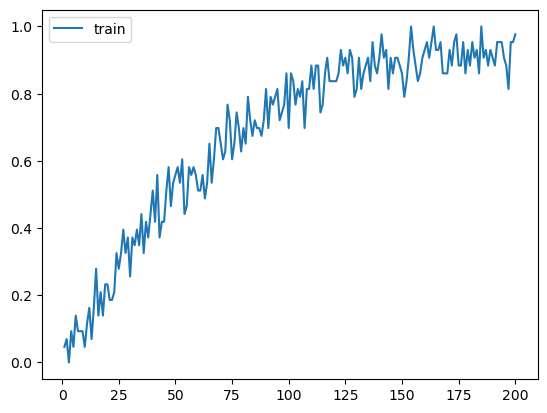

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [97]:
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### Test y validacion

In [98]:
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    return lemma_tokens

def bag_of_words(text, vocab):
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens:
        for idx, word in enumerate(vocab):
            if word == w:
                bow[idx] = 1
    return np.array(bow)

def pred_class(text, vocab, labels):
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0:
        result = model.predict(np.array([bow]))[0]
        thresh = 0.2
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        y_pred.sort(key=lambda x: x[1], reverse=True)

        for r in y_pred:
            return_list.append(labels[r[0]])

    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]
    list_of_intents = intents_json["intents"]
    for i in list_of_intents:
        if i["tag"] == tag:
            result = random.choice(i["responses"])
            break
    return result


In [101]:
qq_attempts = 0
while qq_attempts < 10:
    # Pedir input al usuario
    message = input("")
    print("Pregunta:", message)
    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print("BOT:", result)
    else:
        print("BOT: Perdón, no comprendo la pregunta.")
    qq_attempts += 1
print("Prueba Finalizada")


Pregunta: hola
1/1 [==============================] - 0s 11ms/step
BOT: ¡Hola!
Pregunta: Una consulta, hacen estudios de imagenes?
1/1 [==============================] - 0s 9ms/step
BOT: Contamos con instalaciones de diagnóstico por imágenes en nuestro consultorio. Podemos realizar radiografías, resonancias magnéticas y otros estudios de imagen según la necesidad médica. Por favor, comunícate con nosotros para coordinar una cita.
Pregunta: Quisiera pedir un turno para una radiografia de torax
1/1 [==============================] - 0s 9ms/step
BOT: Puedes solicitar un turno llamando a nuestro número de contacto o visitando nuestra página web.
Pregunta: En que horarios puedo llamar?
1/1 [==============================] - 0s 10ms/step
BOT: Nuestros horarios de atención son de lunes a viernes de 9:00 a.m. a 5:00 p.m.
Pregunta: puedo pagar la consulta con Tarjeta de Credito?
1/1 [==============================] - 0s 10ms/step
BOT: Aceptamos efectivo, tarjetas de crédito y débito. Al finaliz